# Introduction

Dans ce notebook nous explorons les images du jeu de données.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

import seaborn as sns

On récupère le DataFrame enregistré à la fin de l'exploration du texte.

In [2]:
df = pd.read_csv('../data/exploration/exploration.csv')
df.head(3)

productid  prdtypecode                                        designation  \
0  3804725264           10  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1   436067568         2280  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2   201115110           50  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   

                                         description  \
0                                                NaN   
1                                                NaN   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   

                                               image  \
0  ../data/raw/images/image_train/image_126359704...   
1  ../data/raw/images/image_train/image_100814123...   
2  ../data/raw/images/image_train/image_938777978...   

                                 cleaned_designation  \
0  Olivia Personalisiertes Notizbuch 150 Seiten P...   
1  Journal Des Arts (Le) N° 133 Du 28 09 2001 - L...   
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   

                                 cleaned_description  \
0                                                NaN   
1                                                NaN   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   

                                                text         hashed_image  \
0  Olivia Personalisiertes Notizbuch 150 Seiten P...  3636640688090331311   
1  Journal Des Arts (Le) N° 133 Du 28 09 2001 - L... -4957995782022015041   
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo... -8854006323368789122   

                      category            group  cleaned_description_len  \
0           Livres spécialisés  Livres & Revues                        0   
1           Presse & Magazines  Livres & Revues                        0   
2  Accessoires & Périphériques       Jeux Vidéo                      663   

   is_label_issue                                 group_cat detected_lang  \
0           False      Livres & Revues - Livres spécialisés            de   
1           False      Livres & Revues - Presse & Magazines            fr   
2           False  Jeux Vidéo - Accessoires & Périphériques            fr   

   near_duplicated  
0            False  
1            False  
2            False

On définit des fonctions pour récupérer les images à partir des chemins et une fonction pour afficher des grilles d'images. Ensuite, nous affichons quelques images pour chaque catégorie de manière aléatoire.

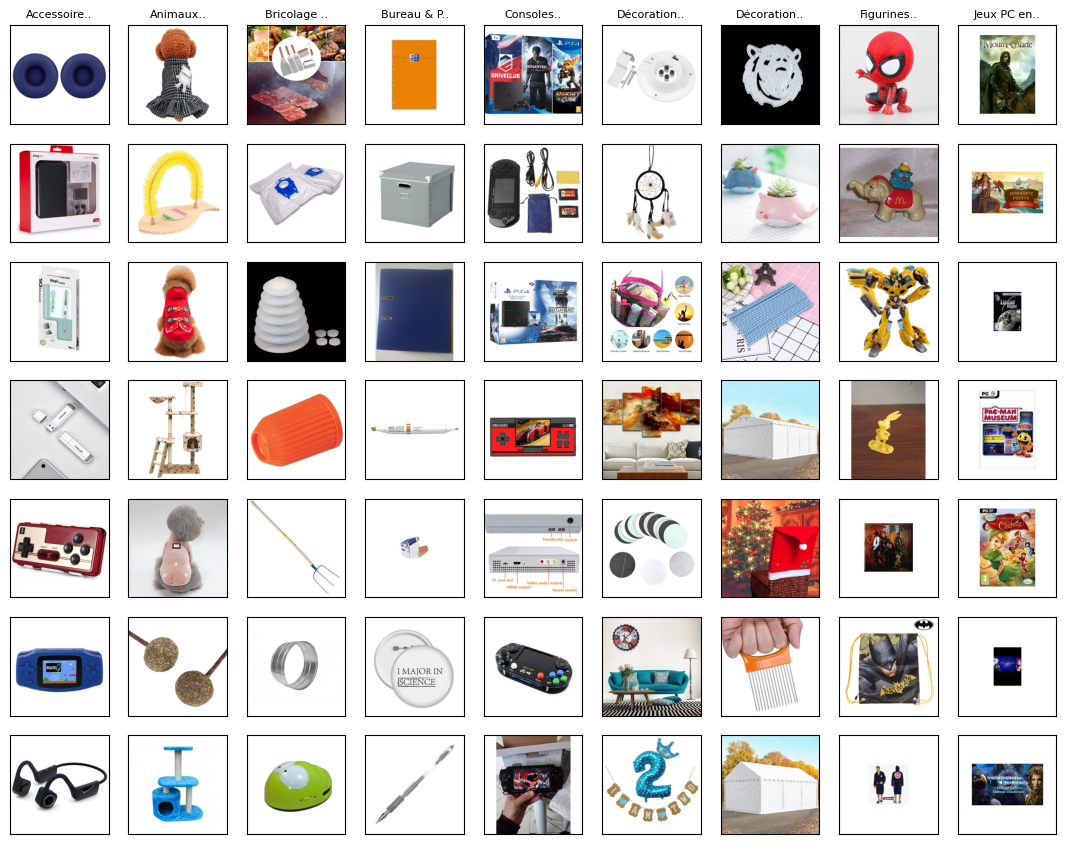

------------------------------------------------------------------------------------------------------------------------------------------------------


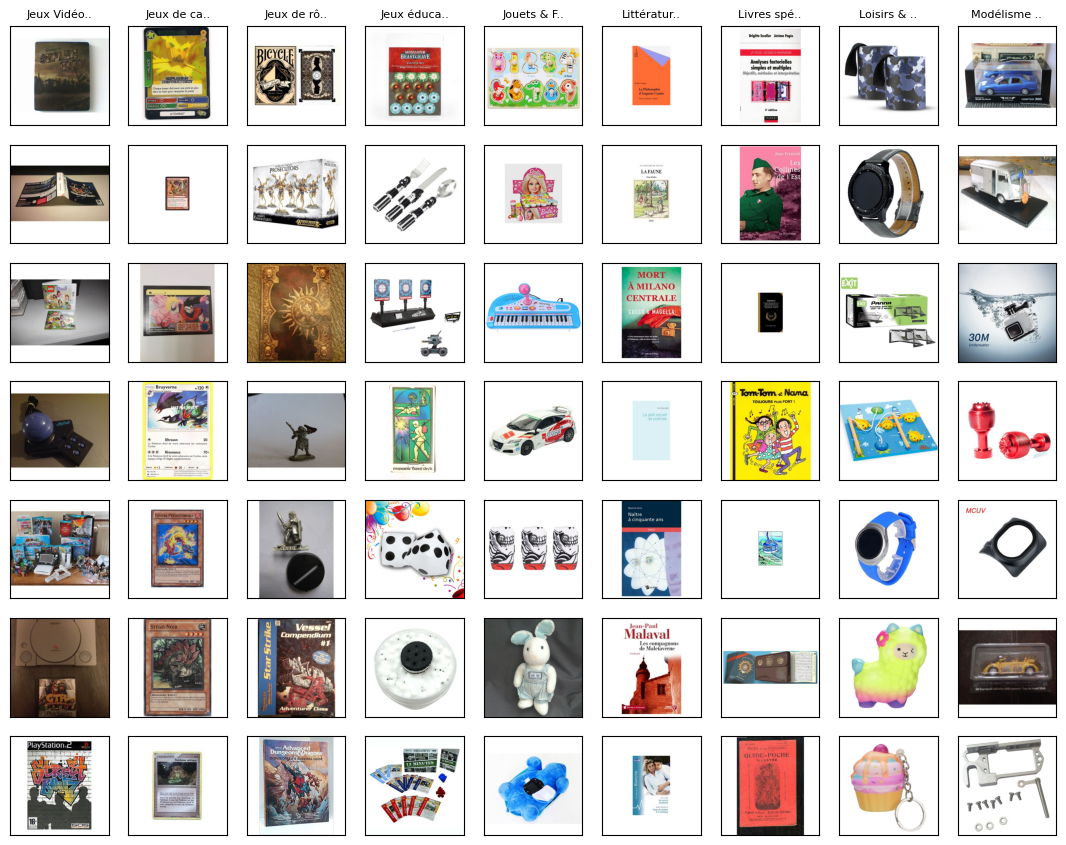

------------------------------------------------------------------------------------------------------------------------------------------------------


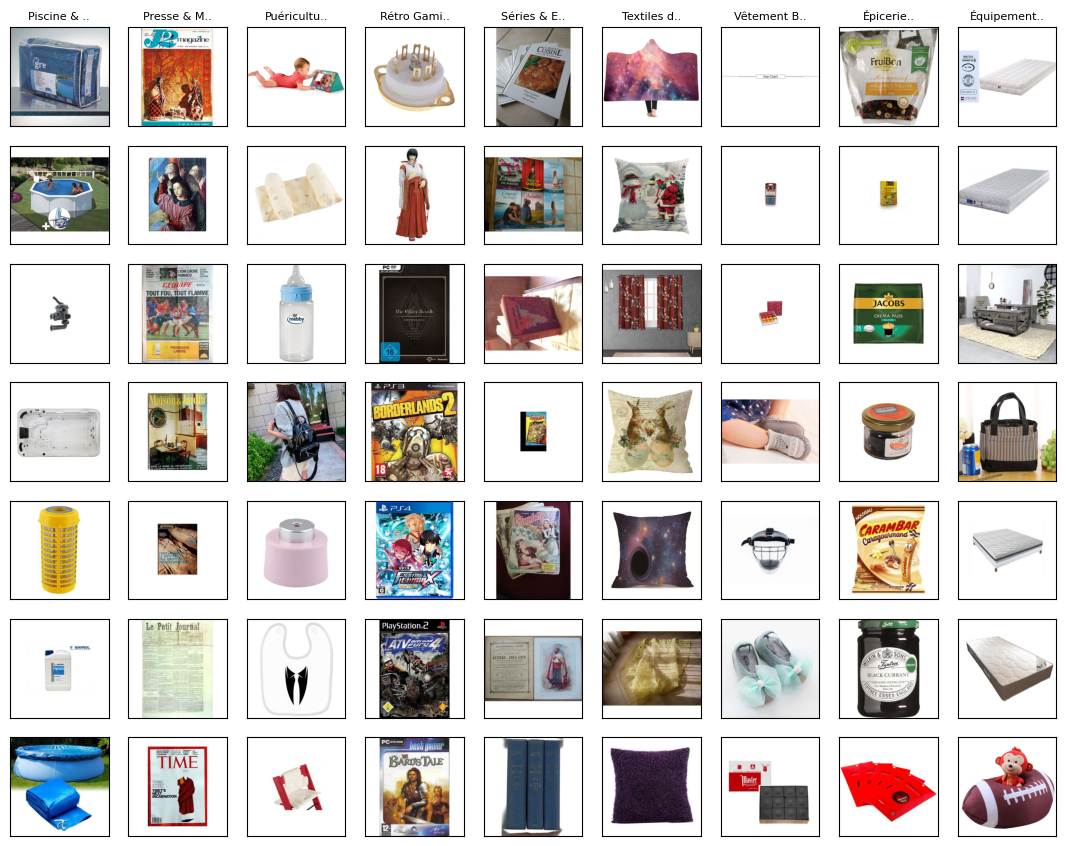

In [ ]:
# max_load représente le nombre d'octet maximum chargé en mémoire 10**9 => 1 Go
# le nombre d'images retourné se fera en fonction de ce paramètre

def images_read(impath, dsize=(500,500), grayscale=False, max_load=10**9):
    n = len(impath)
    total_size = n*dsize[0]*dsize[1] if grayscale else n*dsize[0]*dsize[1]*3
    stop = int(n * (max_load/total_size)) if total_size > max_load else n
    images = []
    # si c'est une Series il faut reindexé par 0, ... ,n pour pouvoir utiliser les indices de la même manière qu'une liste
    if type(impath) == pd.Series:
        impath = impath.reset_index(drop=True)
    if grayscale:
        for i in range(stop):
            im = cv2.imread(impath[i], cv2.IMREAD_GRAYSCALE)
            images.append(cv2.resize(im, dsize = dsize))
    else:
        for i in range(stop):
            im = cv2.imread(impath[i], cv2.IMREAD_COLOR)
            # cv2 encode les images aux formats BGR,
            # on les transforme en RGB pour les afficher correctement avec matplotlib 
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            images.append(cv2.resize(im, dsize = dsize))
    return np.array(images)

def images_grid(images, nrows=5, ncols=10, cmap=None, titles=None, ordered_by_rows=True, axes_size=(1.5, 1.5)):
    fig, axes = plt.subplots(nrows, ncols, figsize=(axes_size[0]*ncols, axes_size[1]*nrows))
    axes = axes.flatten()
    if ordered_by_rows:
        axes_order = range(nrows*ncols)
    else:
        axes_order = [i*ncols + j for j in range(ncols) for i in range(nrows)]
    for i in range(nrows*ncols):
        k = axes_order[i]
        if i < len(images):
            axes[k].imshow(images[i], cmap=cmap)
            if titles:
                axes[k].set_title(titles[i], fontsize=8)
        axes[k].set_xticks([])
        axes[k].set_yticks([])
    plt.show()


N = 7  # nombre d'images par catégories

titles = []
paths = []

for cat in np.sort(df['category'].unique()):
    titles += [cat[:10]+'..'] + [''] * (N-1)
    paths += list(df[df['category'] == cat]['image'].sample(N, random_state=42))
images = images_read(paths)
images_grid(images[:9*N], N, 9, titles=titles[:9*N], ordered_by_rows=False)
print('-'*150)
images_grid(images[9*N:18*N], N, 9, titles=titles[9*N:18*N], ordered_by_rows=False)
print('-'*150)
images_grid(images[18*N:], N, 9, titles=titles[18*N:], ordered_by_rows=False)

Mis à part les catégories de livres et revues qui semblent avoir un cadrage permettant de détecter la forme rectangulaire, il semble être compliqué de determiner les éléments des photos qui caractérisent la catégorie d'un produit. Souvent les couleurs et les formes peuvent varier grandement au sein des catégories.

# LDA
Nous allons projeter les images (réduites en 28x28 et en noir et blanc) sur un plan à partir des deux composantes principales de la LDA.

In [4]:
# fonction prise telle quelle du module "Méthodes de réduction de dimension - Manifold learning"

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.resize(images[i], dsize = (28,28)), cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

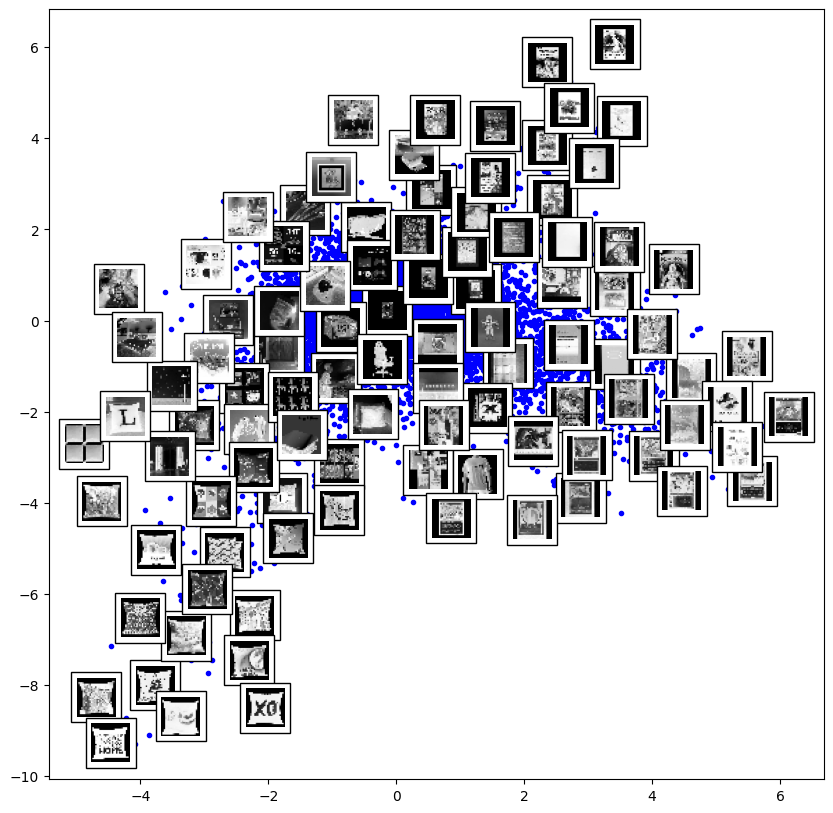

In [7]:
import matplotlib.markers as mmarkers

N = 10000
im28x28 = images_read(df['image'].iloc[:N], dsize=(28,28), grayscale=True)
im28x28 = im28x28.reshape((im28x28.shape[0], im28x28.shape[1]*im28x28.shape[2]))
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(im28x28, df['prdtypecode'][:N])
imt = lda.transform(im28x28)
fig, ax = plt.subplots(figsize=(10, 10))

# pour le nuage de points avec les images
plot_components(imt, lda, im28x28.reshape((-1,28,28)), prefit=True, ax=ax, thumb_frac=0.05)


# pour le deuxième nuage de points
data = pd.DataFrame({
    'x': imt[:, 0],
    'y': imt[:, 1],
    'groupe': df['group'].iloc[:len(imt)],
    'categorie': df['category'].iloc[:len(imt)]
})

groups = sorted(data['groupe'].unique())

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in np.linspace(0, 1, len(groups))]
markers = list(mmarkers.MarkerStyle.markers.keys())[1:]

plt.figure(figsize=(12,10))

for i, group in enumerate(groups):
    cats = sorted(data[data['groupe']==group]['categorie'].unique())
    for j, cat in enumerate(cats):
        subset = data[(data["categorie"] == cat) & (data["groupe"] == group)]
        plt.scatter(subset["x"], subset['y'], color=colors[i], marker=markers[j], label=cat, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.show()

Seule la catégorie textile d'intérieur semble facilement se démarquer (en bas à gauche). Dans cette catégorie ce sont essentiellement les images de coussins et d'oreillers qui semblent être discriminées.
En haut à droite on voit des objets plus rectangulaires souvent des livres et des revues. Nous allons maintenant essayer la même chose avec l'utilisation du t-SNE.

# t-SNE

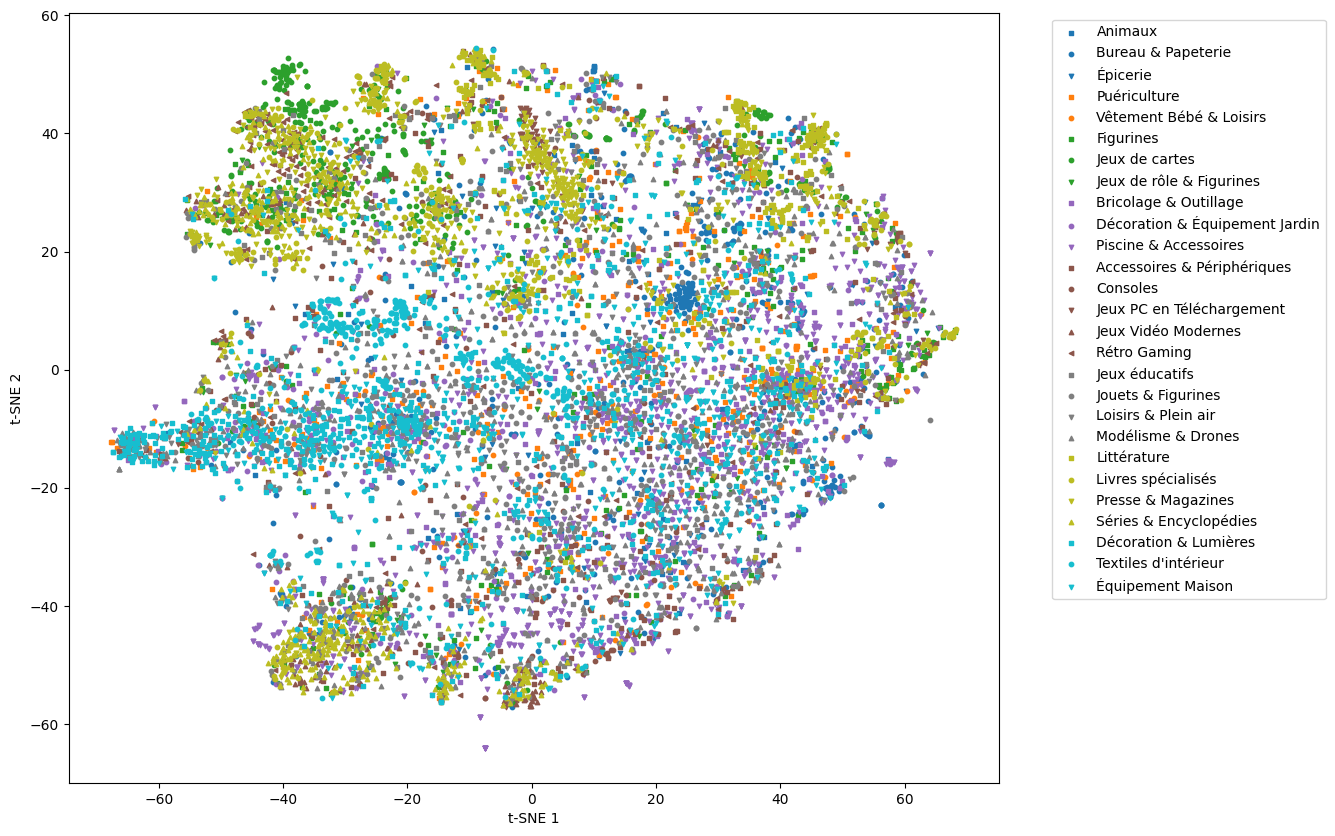

In [8]:
tsne = TSNE(n_components=2)
imt = tsne.fit_transform(im28x28)

fig, ax = plt.subplots(figsize=(10, 10))

# pour le nuage de points avec les images
plot_components(imt, tsne, im28x28[:N].reshape((-1,28,28)), prefit=True, ax=ax, thumb_frac=0.05)


# pour le deuxième nuage de points
data = pd.DataFrame({
    'x': imt[:, 0],
    'y': imt[:, 1],
    'groupe': df['group'].iloc[:len(imt)],
    'categorie': df['category'].iloc[:len(imt)]
})

groups = sorted(data['groupe'].unique())

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in np.linspace(0, 1, len(groups))]
markers = list(mmarkers.MarkerStyle.markers.keys())[1:]

plt.figure(figsize=(12,10))

for i, group in enumerate(groups):
    cats = sorted(data[data['groupe']==group]['categorie'].unique())
    for j, cat in enumerate(cats):
        subset = data[(data["categorie"] == cat) & (data["groupe"] == group)]
        plt.scatter(subset["x"], subset['y'], color=colors[i], marker=markers[j], label=cat, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Ici on voit que l'axe des absisses permet de distinguer les photos foncées des photos claires.
Pour l'axe des ordonnées c'est moins évident mais il semble que les objets plus 'aplatis' sont en bas et ceux qui sont plus en hauteur sont en haut.